In [1]:
"""PATHS & DIRS"""
from pathlib import Path

try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_ROOT = Path("/content/data")
    SAVE_DIR = Path("/content/drive/MyDrive/research/vision_transformer")
    CHECKPOINT_DIR = SAVE_DIR/"vit_caltech_checkpoints"
    EXPERIMENT_DIR = SAVE_DIR/"experiments"
except:
    DATA_ROOT = Path.home()/"Desktop/research"
    CHECKPOINT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints"
    EXPERIMENT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/experiments"

if not DATA_ROOT.exists():
    DATA_ROOT.mkdir()
    print("Created Data dir")
else:
    print("DATA_ROOT exists at : ", DATA_ROOT)
    
if not CHECKPOINT_DIR.exists():
    CHECKPOINT_DIR.mkdir()
    print("created CKPT dir")
else:
    print("ckpt exists at : ", CHECKPOINT_DIR)

DATA_ROOT exists at :  /home/avishkar/Desktop/research
created CKPT dir


In [7]:
"""DATASET"""
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
!pip install gdown
def to_rgb(image):
  """Converts a grayscale image to RGB format."""
  if len(image.getbands()) == 1:
    # Add two dummy channels to make it RGB
    return image.convert('RGB')
  else:
    return image

NUM_WORKERS = 2
BATCH_SIZE = 32 

transform = transforms.Compose([
  transforms.Lambda(to_rgb),
    transforms.Resize((128, 128)),  # Resize images 64x64 : caltech101 has pics of around 200x300 
    transforms.ToTensor(),           # Convert images to tensors
])

dataset = datasets.Caltech101(DATA_ROOT, transform=transform, download=True)
# dataset = datasets.Caltech101(DATA_ROOT, transform=transform, download=True)
print("Dataset size : ",len(dataset))
indices = list(range(len(dataset)))

split = int(0.8 * len(dataset))
train_indices, test_indices = indices[:split], indices[split:]

# Create training and test subsets using Subset
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Defaulting to user installation because normal site-packages is not writeable
Files already downloaded and verified
Dataset size :  8677


Defaulting to user installation because normal site-packages is not writeable


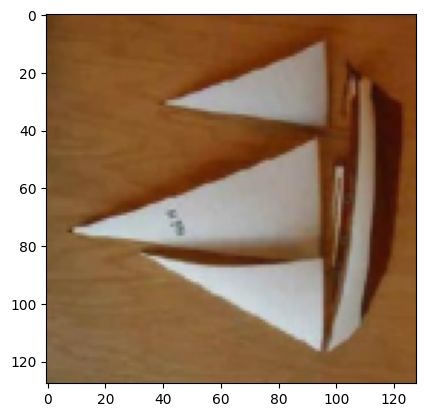

In [10]:
"""VISUALIZE DATA"""
!pip install scipy
import matplotlib.pyplot as plt

for i, (imgs, labels) in enumerate(train_loader):
    img = imgs[0]
    plt.imshow(img.T.cpu().numpy())
    plt.show()
    break
    

In [11]:
"""MODEL"""

import torch.nn as nn
import torch.nn.functional as F
import math

class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.img_size = config["img_size"]
        self.num_channels = config["num_channels"]
        self.patch_size = config["patch_size"]
        self.embed_dim = config["embed_dim"]
        
        self.num_patches = (self.img_size//self.patch_size)**2
        self.projection = nn.Conv2d(self.num_channels, self.embed_dim, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.projection(x)
        # print(x.shape)
        x = x.flatten(2).transpose(1,2)
        return x


class Embeddings(nn.Module):
    # Patch Embeddings + (CLS Token + Positional Embeddings )
    def __init__(self, config):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(config)
        self.embed_dim = config["embed_dim"]
        self.cls_token = nn.Parameter(torch.randn(1,1,self.embed_dim))
        self.positional_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches+1, self.embed_dim))
        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_token = self.cls_token.expand(batch_size, -1, -1) # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.positional_embeddings
        x = self.dropout(x)
        return x

class AttentionHead(nn.Module):
    def __init__(self, attention_head_size,config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.attention_head_size = attention_head_size
        self.bias = config["bias"]
        
        self.query = nn.Linear(self.embed_dim, self.attention_head_size, bias=self.bias)
        self.key = nn.Linear(self.embed_dim, self.attention_head_size, bias=self.bias)
        self.value = nn.Linear(self.embed_dim, self.attention_head_size, bias=self.bias)

        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attention_scores = torch.matmul(q, k.transpose(-1,-2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_scores = nn.functional.softmax(attention_scores, dim=-1)
        attention_scores = self.dropout(attention_scores)
        attention_out = torch.matmul(attention_scores, v)
        
        return attention_out

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.num_heads = config["num_heads"]
        self.head_size = self.embed_dim//self.num_heads
        self.all_head_size = self.head_size * self.num_heads
        self.dropout = config["dropout"]
        self.qkv_bias = config["bias"]

        self.heads = nn.ModuleList([
            AttentionHead(
                self.head_size,
                config
            ) for _ in range(self.num_heads)
        ])

        self.attention_mlp = nn.Linear(self.all_head_size, self.embed_dim)
        self.out_dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output in attention_outputs], dim=-1) #concat attention for each head
        attention_output = self.attention_mlp(attention_output)
        attention_output = self.out_dropout(attention_output)

        return attention_output
        

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.fc1 = nn.Linear(self.embed_dim, self.hidden_dim)
        # self.act = nn.GELU()
        self.act=NewGELUActivation()
        self.fc2 = nn.Linear(self.hidden_dim, self.embed_dim)
        self.dropout=nn.Dropout(config["dropout"])

    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim=config["embed_dim"]
        self.num_heads = config["num_heads"]
        self.hidden_dim = config["hidden_dim"]
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.mlp = MLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)

    def forward(self,x):
        attention_output = self.attention(self.layer_norm1(x))
        x = x+attention_output
        mlp_out = self.mlp(self.layer_norm2(x))
        x = x+mlp_out
        return x
        
    
class Encoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.blocks = nn.ModuleList([Block(config) for _ in range(config["num_hidden_layers"])])
    def forward(self,x ):
        all_attentions = []
        for block in self.blocks:
            x = block(x)
        return x


class ViT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.img_size = config["img_size"]
        self.embed_dim = config["embed_dim"]
        self.num_classes = config["num_classes"]
    
        self.embeddings = Embeddings(config)
        self.encoder = Encoder(config)
    
        self.classifier = nn.Linear(self.embed_dim, self.num_classes)

        self.apply(self._init_weights)

    def forward(self, x):
        embedding_output = self.embeddings(x)
        encoder_output = self.encoder(embedding_output)
        classification = self.classifier(encoder_output[:, 0, :])
        return classification


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.positional_embeddings.data = nn.init.trunc_normal_(
                module.positional_embeddings.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.positional_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.cls_token.dtype)

            


In [12]:
"""UTILS"""
import json
from pathlib import Path

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "accuracies":accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    
    

In [13]:
"""CONFIG"""



config = {
    "img_size":128,
    "patch_size":16,
    "num_channels":3,
    "embed_dim":48,
    "dropout":0.0,
    "bias":True,
    "num_heads":4,
    "hidden_dim":4*48,
    "num_hidden_layers":7,
    "num_classes":101,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "exp_name" : 'vit-caltect101-5-epochs',
    "num_epochs":5,
    "lr":0.01,
    "save_model_every" :0

}

In [14]:
import torch.optim as optim
import torch
class Trainer:
    def __init__(self, model, optimizer, criterion, device, path=CHECKPOINT_DIR):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.path=path
        self.exp_dir = EXPERIMENT_DIR

    def train(self, train_loader, test_loader, num_epochs, save_model_every_n_epochs=0):
        train_losses = []
        test_losses = []
        accuracies = [] 

        for i in range(num_epochs):
            train_loss = self.train_epoch(train_loader)
            accuracy, test_loss = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != num_epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.model.state_dict(), i+1, train_losses, test_losses, accuracies, self.path)

        save_experiment(self.model, num_epochs, config, train_losses, test_losses, accuracies, self.exp_dir)

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()* len(imgs)

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for i, (imgs, labels) in enumerate(test_loader):
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                predictions = self.model(imgs)
                
                loss = self.criterion(predictions, labels)
                total_loss += loss.item() * len(imgs)

                 # Calculate the accuracy
                predictions = torch.argmax(predictions, dim=1)
                correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(test_loader.dataset)
        avg_loss = total_loss / len(test_loader.dataset)
        return accuracy, avg_loss
            

def main():
    save_model_every_n_epochs = config["save_model_every"]
    model = ViT(config)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, criterion, device=config["device"])
    trainer.train(train_loader, test_loader, config["num_epochs"], save_model_every_n_epochs=save_model_every_n_epochs)

In [15]:
"""TRAINING"""

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

In [ ]:
"""VIS Loss, ACC"""

"""
def load_experiment(model ,exp_name, path):
    data = json.load(path/f"exp_name"/"metrics.json")
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    """


import matplotlib.pyplot as plt

model = ViT(config)
_, train_losses, test_losses, accuracies,_ = load_experiment(model, config["exp_name"], EXPERIMENT_DIR)
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()